In [13]:
import warnings
warnings.filterwarnings('ignore')

import sys
pkg_path = "/nfs/students/winter-term-2020/project-1/project-1/"
if pkg_path not in sys.path:
    sys.path.append(pkg_path)

import types
import time
import yaml
import torch
from audio_classification.tools import do_train, get_dataloader, get_model, get_transform
from audio_classification.tools.train_net import collate
from audio_classification.model import lit_m11, LitCRNN
from audio_classification.data import UrbanSoundDataset, BMWDataset

from foolbox import PyTorchModel, accuracy, samples
from foolbox.attacks import LinfPGD, L2PGD, FGM, FGSM, L2AdditiveGaussianNoiseAttack, L2AdditiveUniformNoiseAttack, L2ClippingAwareAdditiveGaussianNoiseAttack, L2ClippingAwareAdditiveUniformNoiseAttack

from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# instantiate a model 
with open("../audio_classification/configs/crnn_urbansound8k.yaml", "r") as config_file:
    configs = yaml.load(config_file)
path_to_checkpoint = '../weights/' + 'crnn-us8k-epoch=17-val_acc=0.755.ckpt'
_, _, _, class_weight = get_dataloader(configs, trial_hparams = None, transform=get_transform(configs))

In [3]:
model = LitCRNN.load_from_checkpoint(path_to_checkpoint, cfg=configs, class_weights=torch.tensor(class_weight).to(device='cuda'))
fmodel = PyTorchModel(model, bounds=(-200, 200))
# use validattion set
val_set = UrbanSoundDataset(configs, [1], transform=get_transform(configs))
val_loader = DataLoader(val_set, batch_size=10, shuffle=True,
                                num_workers=configs["DATALOADER"]["NUM_WORKERS"],
                                pin_memory=True, collate_fn = collate)
it = iter(val_loader)

/nfs/homedirs/nikoghos/anaconda3/lib/python3.8/site-packages/foolbox/models/pytorch.py:36: UserWarning: The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.
  warnings.warn(


In [11]:
# evaluate accuracy on clean data on a batch
device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
batch = next(it)
clips = batch[0].to(device)
labels = batch[1].to(device)
lengths = batch[2].to(device)   # used only for CRNN
out = model(clips, lengths)
preds = torch.argmax(out, dim=1)

accuracy = torch.mean(preds==labels, dtype=float)

In [16]:
# Visualize adverserial sample
attack = FGM()
raw, clipped, is_adv = attack(fmodel, clips, labels, epsilons=40)

is_adv = is_adv.cpu()
clipped = clipped.cpu()
print("It is %s that this is an adverserial sample." %(is_adv[16]))
plt.pcolormesh(clipped[16].squeeze().numpy(), shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

TypeError: __call__() takes 2 positional arguments but 3 were given

In [23]:
# The predicted class of the adverserial sample
out = model(labels[8], lengths[8])
pred = torch.argmax(out, dim=1)
print(pred)

RuntimeError: Expected 4-dimensional input for 4-dimensional weight [64, 1, 3, 3], but got 0-dimensional input of size [] instead

label tensor(8)
torch.Size([1, 96, 1501])


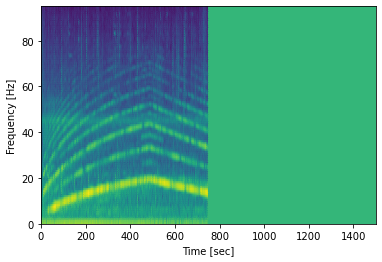

In [26]:
# Visualize original sample
sample = batch[0]
print("label %s" %(batch[1][8]))
print(sample[8].shape)
plt.pcolormesh(sample[8].squeeze().numpy(), shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

In [27]:
attack = LinfPGD()
epsilons = np.linspace(0.0, 0.5, num=50)

start_time = time.perf_counter()
raw, clipped, is_adv = attack(fmodel, clips, labels, epsilons=epsilons)
end_time = time.perf_counter()
print(f"Generated attacks in {end_time - start_time:0.2f} seconds")

robust_accuracy = 1 - is_adv.double().mean(axis=-1)

TypeError: forward() missing 1 required positional argument: 'seq_lens'

NameError: name 'robust_accuracy' is not defined

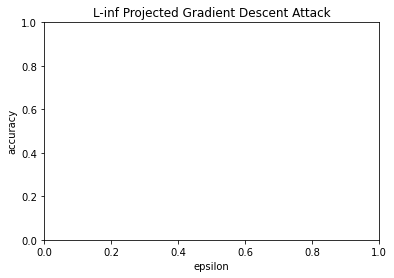

In [28]:
plt.title("L-inf Projected Gradient Descent Attack")
plt.xlabel("epsilon")
plt.ylabel("accuracy")
plt.plot(epsilons, robust_accuracy.to('cpu').numpy())

In [ ]:
# evaluate robustness with L-2 projected gradient descent attack
attack = L2PGD()
epsilons = np.linspace(0.0, 40, num=50)

start_time = time.perf_counter()
raw, clipped, is_adv = attack(fmodel, clips, labels, epsilons=epsilons)
end_time = time.perf_counter()
print(f"Generated attacks in {end_time - start_time:0.2f} seconds")

robust_accuracy = 1 - is_adv.double().mean(axis=-1)

In [ ]:
plt.title("L-2 Projected Gradient Descent Attack")
plt.xlabel("epsilon")
plt.ylabel("accuracy")
plt.plot(epsilons, robust_accuracy.to('cpu').numpy())

In [ ]:
# evaluate robustness with L-2 Fast Gradient Attack
attack = FGM()
epsilons = np.linspace(0.0, 40, num=200)

start_time = time.perf_counter()
raw, clipped, is_adv = attack(fmodel, clips, labels, epsilons=epsilons)
end_time = time.perf_counter()
print(f"Generated attacks in {end_time - start_time:0.2f} seconds")

robust_accuracy = 1 - is_adv.double().mean(axis=-1)

In [ ]:
plt.title("L-2 Fast Gradient Attack")
plt.xlabel("epsilon")
plt.ylabel("accuracy")
plt.plot(epsilons, robust_accuracy.to('cpu').numpy())

In [ ]:
# evaluate robustness with L-inf Fast Gradient Attack
attack = FGSM()
epsilons = np.linspace(0.0, 0.5, num=200)

start_time = time.perf_counter()
raw, clipped, is_adv = attack(fmodel, clips, labels, epsilons=epsilons)
end_time = time.perf_counter()
print(f"Generated attacks in {end_time - start_time:0.2f} seconds")

robust_accuracy = 1 - is_adv.double().mean(axis=-1)

In [ ]:
plt.title("L-inf Fast Gradient Attack")
plt.xlabel("epsilon")
plt.ylabel("accuracy")
plt.plot(epsilons, robust_accuracy.to('cpu').numpy())

In [ ]:
# evaluate robustness with L-2 Additive Gaussian Noise Attack
attack = L2ClippingAwareAdditiveGaussianNoiseAttack()
epsilons = np.linspace(0.0, 40, num=200)

start_time = time.perf_counter()
raw, clipped, is_adv = attack(fmodel, clips, labels, epsilons=epsilons)
end_time = time.perf_counter()
print(f"Generated attacks in {end_time - start_time:0.2f} seconds")

robust_accuracy = 1 - is_adv.double().mean(axis=-1) 

In [ ]:
plt.title("L-2 Clipping-Aware Additive Gaussian Noise Attack")
plt.xlabel("epsilon")
plt.ylabel("accuracy")
plt.plot(epsilons, robust_accuracy.to('cpu').numpy())